# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [161]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

In [156]:
%matplotlib notebook
import datetime
# read in csv
weather = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')

# date is a str, make into datetime object
weather['DateTime'] = pd.to_datetime(weather['Date'], format = '%Y-%m-%d')

# work with 2005-2014
weather05_14 = weather[weather['DateTime'].dt.year != 2015]
# delete every leap day
weather05_14 = weather05_14[~((weather05_14['DateTime'].dt.month == 2) & (weather05_14['DateTime'].dt.day == 29))]
# we don't need year, change every year to a non-leap year dummy value to avoid confusion
weather05_14['DateTime'] = weather05_14['DateTime'].map(lambda x: pd.datetime(2014, x.month, x.day))
# %j gives day of the year, up to 365 because of the year value change above
weather05_14['DoY'] = weather05_14['DateTime'].dt.strftime('%j')
# max and min temps per day of year
weather05_14 = weather05_14[['Data_Value','DoY']].groupby('DoY').agg(['min', 'max'])
# temps are originally in tenths of degrees celsius, change to degrees
weather05_14['TempMin'] = weather05_14['Data_Value']['min'] / 10
weather05_14['TempMax'] = weather05_14['Data_Value']['max'] / 10

In [157]:
# do the same for 2015 data, add day of year and convert to degrees
weather15 = weather[weather['DateTime'].dt.year == 2015]
weather15
weather15['DoY'] = weather15['DateTime'].dt.strftime('%j')
weather15 = weather15[['Data_Value','DoY']].groupby('DoY').agg(['min', 'max'])
weather15['TempMin'] = weather15['Data_Value']['min'] / 10
weather15['TempMax'] = weather15['Data_Value']['max'] / 10
# compare value to 05-14, if less extreme then make the value empty
weather15['TempMinC'] = [row if row < row2 else None for row, row2 in zip(weather15['TempMin'], weather05_14['TempMin'])]
weather15['TempMaxC'] = [row if row > row2 else None for row, row2 in zip(weather15['TempMax'], weather05_14['TempMax'])]

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


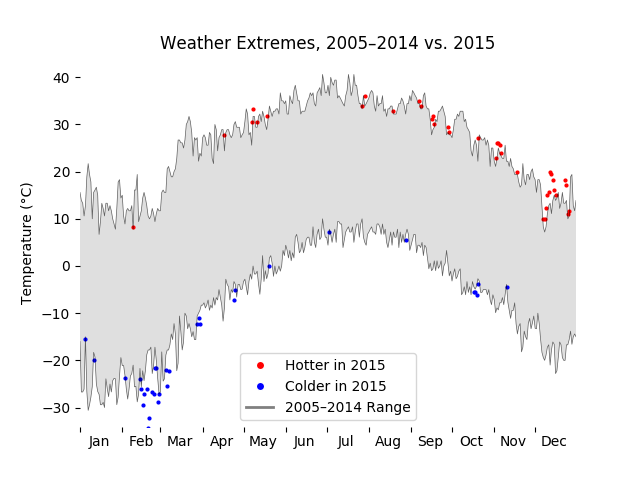

/opt/conda/lib/python3.5/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom". Falling back on "best"; valid locations are
	upper center
	center right
	center
	center left
	lower left
	best
	lower center
	lower right
	upper left
	upper right
	right

  six.iterkeys(self.codes))))


In [159]:
from datetime import datetime
from matplotlib import dates, ticker
from matplotlib.lines import Line2D
    
fig, ax = plt.subplots()
# plot extremes from 2005 to 2014
ax.plot(weather05_14.index, weather05_14['TempMin'], 'black', linewidth = .5, alpha = 0.6)
ax.plot(weather05_14.index, weather05_14['TempMax'], 'black', linewidth = .5, alpha = 0.6)
ax.fill_between(weather05_14.index.astype(int), weather05_14['TempMin'], weather05_14['TempMax'],
                 facecolor = 'grey', alpha = 0.25)

ax.margins(x = 0)

# setup your date values (arbitrary year)
oneday = datetime(1990, 1, 2) - datetime(1990, 1, 1)
start = datetime(1990, 1, 1)
end = datetime(1991, 1, 1)
date = dates.drange(start, end, oneday)

for spine in plt.gca().spines.values():
    spine.set_visible(False)

templabel = "Temperature (" + chr(176) + "C)"
plt.ylabel(templabel)

# convert day of year (1-365) x axis labels to months
# set locators, offset one by 15 days (half a month)
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

# remove ticks under labels
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
# keep axis bounds static    
ax.autoscale(enable = False)
ax.scatter(weather15.index.astype(int), weather15['TempMinC'], s = 4, c = 'b')
ax.scatter(weather15.index.astype(int), weather15['TempMaxC'], s = 4, c = 'r')

leg_labels = [Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize = 6),
              Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize = 6),
              Line2D([0], [0], color = 'grey', lw = 2)]
ax.legend(leg_labels, ['Hotter in 2015', 'Colder in 2015', '2005–2014 Range'], loc = 'bottom')

ax.set_title('Weather Extremes, 2005–2014 vs. 2015')
plt.savefig('weather.jpg', bbox_inches = 'tight',  transparent = False)